Usando dispositivo: cuda
Epoch 1/30 - Train loss: 1.7034 accuracy: 0.3355 - Val loss: 1.4622 accuracy: 0.4319
Epoch 2/30 - Train loss: 1.4270 accuracy: 0.4490 - Val loss: 1.4005 accuracy: 0.4636
Epoch 3/30 - Train loss: 1.2929 accuracy: 0.5043 - Val loss: 1.2523 accuracy: 0.5183
Epoch 4/30 - Train loss: 1.1962 accuracy: 0.5406 - Val loss: 1.1870 accuracy: 0.5411
Epoch 5/30 - Train loss: 1.0891 accuracy: 0.5846 - Val loss: 1.1914 accuracy: 0.5358
Epoch 6/30 - Train loss: 1.0007 accuracy: 0.6208 - Val loss: 1.1959 accuracy: 0.5469
Epoch 7/30 - Train loss: 0.9137 accuracy: 0.6534 - Val loss: 1.1729 accuracy: 0.5695
Epoch 8/30 - Train loss: 0.8127 accuracy: 0.6941 - Val loss: 1.2120 accuracy: 0.5793
Epoch 9/30 - Train loss: 0.7222 accuracy: 0.7278 - Val loss: 1.2338 accuracy: 0.5762
Epoch 10/30 - Train loss: 0.6438 accuracy: 0.7567 - Val loss: 1.2921 accuracy: 0.5759
Epoch 11/30 - Train loss: 0.5621 accuracy: 0.7883 - Val loss: 1.3624 accuracy: 0.5748
Epoch 12/30 - Train loss: 0.4980 accur

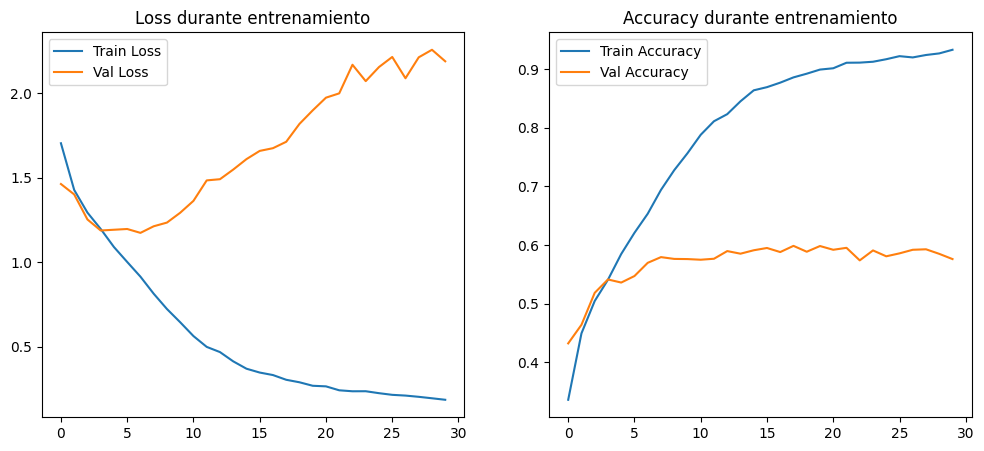

Modelo guardado a emotion_cnn_model.pth


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Verifica dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Dataset personalizado para FER2013
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, usage="Training", transform=None):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.loc[idx, 'pixels']
        pixels = np.array(list(map(int, pixels.split()))).reshape(48, 48).astype(np.uint8)
        label = self.data.loc[idx, 'emotion']

        if self.transform:
            pixels = self.transform(pixels)
        else:
            pixels = pixels.astype(np.float32) / 255.0
            pixels = np.expand_dims(pixels, 0)  # (1, 48, 48)
            pixels = torch.tensor(pixels)

        label = torch.tensor(label).long()
        return pixels, label

# Definición simple de una CNN para emociones
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*6*6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Función de entrenamiento
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss/total, correct/total

# Función de validación
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss/total, correct/total


# Parámetros
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.001
CSV_PATH = 'fer2013.csv'  # Ajusta aquí la ruta si hace falta

# Dataset y DataLoader
train_dataset = FER2013Dataset(CSV_PATH, usage='Training')
val_dataset = FER2013Dataset(CSV_PATH, usage='PublicTest')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Crear modelo
model = EmotionCNN().to(device)

# Pérdida y optmizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Entrenamiento
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch}/{EPOCHS} - "
          f"Train loss: {train_loss:.4f} accuracy: {train_acc:.4f} - "
          f"Val loss: {val_loss:.4f} accuracy: {val_acc:.4f}")

# Mostrar curvas
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss durante entrenamiento')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy durante entrenamiento')
plt.legend()

plt.show()

# Guardar modelo entrenado
torch.save(model.state_dict(), 'emotion_cnn_model.pth')
print('Modelo guardado a emotion_cnn_model.pth')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====== Configuración GPU ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Usando dispositivo:', device)

# ====== Dataset personalizado para FER2013 ======
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, usage="Training", transform=None):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.loc[idx, 'pixels']
        pixels = np.array(list(map(int, pixels.split())))
        pixels = pixels.reshape(48, 48).astype(np.uint8)
        label = self.data.loc[idx, 'emotion']
        
        if self.transform:
            pixels = self.transform(pixels)
        else:
            pixels = pixels.astype(np.float32)/255.0
            pixels = np.expand_dims(pixels, 0)
            pixels = torch.tensor(pixels)
        label = torch.tensor(label).long()
        return pixels, label

# ====== Modelo CNN simple ======
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*6*6, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 7)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ====== Early Stopping ======
class EarlyStopping:
    def __init__(self, patience=7, delta=0.001, path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_val_loss = float('inf')
        self.path = path
        self.best_model_state = None
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.best_val_loss = val_loss

# Funciones de entrenamiento/validación:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss/total, correct/total

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss/total, correct/total

# ====== Parámetros ======
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
CSV_PATH = 'fer2013.csv'     # Ajusta aquí la ruta si hace falta
BEST_MODEL_PATH = 'best_emotion_cnn_model.pth'

train_dataset = FER2013Dataset(CSV_PATH, usage='Training')
val_dataset = FER2013Dataset(CSV_PATH, usage='PublicTest')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
early_stopping = EarlyStopping(patience=7, delta=0.001, path=BEST_MODEL_PATH)

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch}/{EPOCHS} | Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f}")
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f"✔️ Early stopping activado en la época {epoch}")
        break

# ====== Visualización de curvas ======
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss durante entrenamiento')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Acc durante entrenamiento')
plt.legend()
plt.show()

# ====== Recupera el mejor modelo ======
model.load_state_dict(torch.load(BEST_MODEL_PATH))
print(f'Modelo óptimo restaurado desde {BEST_MODEL_PATH}')


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CONFIGURACIÓN
BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 1e-3
PATIENCE = 7

# Definición del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Dataset personalizado usando transformaciones
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, usage="Training", transform=None):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array(list(map(int, self.data.loc[idx, 'pixels'].split()))).reshape(48,48).astype(np.uint8)
        label = self.data.loc[idx, 'emotion']
        if self.transform:
            pixels = self.transform(pixels)
        else:
            pixels = torch.tensor(pixels, dtype=torch.float32).unsqueeze(0) / 255.0
        label = torch.tensor(label, dtype=torch.long)
        return pixels, label

# Transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(48, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Carga datasets con transform
train_dataset = FER2013Dataset('fer2013.csv', usage='Training', transform=train_transform)
val_dataset = FER2013Dataset('fer2013.csv', usage='PublicTest', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Modelo con más profundidad y dropout
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = EmotionCNN().to(device)

# Funciones para entrenamiento y validación
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Early Stopping simple
class EarlyStopping:
    def __init__(self, patience=PATIENCE, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def step(self, loss):
        if self.best_loss is None or loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping()

for epoch in range(1, EPOCHS+1):
    # Entrenamiento
    model.train()
    running_loss = 0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)

    # Validación
    model.eval()
    val_loss = 0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            val_corrects += (preds == labels).sum().item()
    val_loss /= len(val_dataset)
    val_acc = val_corrects / len(val_dataset)

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    early_stopping.step(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping activado en la época {epoch}")
        break

# Guardar el modelo
torch.save(model.state_dict(), 'best_model.pth')
print("Modelo guardado como best_model.pth")


Usando dispositivo: cuda


c:\Users\Javier\anaconda3\envs\VC_P5_emotions\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40 | Train Loss: 1.8992 Acc: 0.2531 | Val Loss: 1.6814 Acc: 0.3179
Epoch 2/40 | Train Loss: 1.6578 Acc: 0.3312 | Val Loss: 1.4724 Acc: 0.4299
Epoch 3/40 | Train Loss: 1.5637 Acc: 0.3841 | Val Loss: 1.3964 Acc: 0.4450
Epoch 4/40 | Train Loss: 1.5151 Acc: 0.4054 | Val Loss: 1.3652 Acc: 0.4762
Epoch 5/40 | Train Loss: 1.4837 Acc: 0.4212 | Val Loss: 1.3352 Acc: 0.4940
Epoch 6/40 | Train Loss: 1.4541 Acc: 0.4308 | Val Loss: 1.2960 Acc: 0.5043
Epoch 7/40 | Train Loss: 1.4342 Acc: 0.4412 | Val Loss: 1.2845 Acc: 0.5093
Epoch 8/40 | Train Loss: 1.4119 Acc: 0.4501 | Val Loss: 1.2711 Acc: 0.5180
Epoch 9/40 | Train Loss: 1.3941 Acc: 0.4573 | Val Loss: 1.2676 Acc: 0.5311
Epoch 10/40 | Train Loss: 1.3771 Acc: 0.4646 | Val Loss: 1.2530 Acc: 0.5297
Epoch 11/40 | Train Loss: 1.3647 Acc: 0.4701 | Val Loss: 1.2216 Acc: 0.5291
Epoch 12/40 | Train Loss: 1.3519 Acc: 0.4753 | Val Loss: 1.2159 Acc: 0.5428
Epoch 13/40 | Train Loss: 1.3346 Acc: 0.4831 | Val Loss: 1.2086 Acc: 0.5386
Epoch 14/40 | Train L

Usando: cuda
Train: 28709 | Val: 3589


c:\Users\Javier\anaconda3\envs\VC_P5_emotions\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/50 | Train Acc: 0.484 | Val Acc: 0.592
✓ Modelo guardado (Val Acc: 0.592)
Epoch 02/50 | Train Acc: 0.586 | Val Acc: 0.624
✓ Modelo guardado (Val Acc: 0.624)
Epoch 03/50 | Train Acc: 0.612 | Val Acc: 0.633
✓ Modelo guardado (Val Acc: 0.633)
Epoch 04/50 | Train Acc: 0.627 | Val Acc: 0.639
✓ Modelo guardado (Val Acc: 0.639)
Epoch 05/50 | Train Acc: 0.645 | Val Acc: 0.664
✓ Modelo guardado (Val Acc: 0.664)
Epoch 06/50 | Train Acc: 0.661 | Val Acc: 0.659
Epoch 07/50 | Train Acc: 0.669 | Val Acc: 0.667
✓ Modelo guardado (Val Acc: 0.667)
Epoch 08/50 | Train Acc: 0.683 | Val Acc: 0.670
✓ Modelo guardado (Val Acc: 0.670)
Epoch 09/50 | Train Acc: 0.693 | Val Acc: 0.668
Epoch 10/50 | Train Acc: 0.706 | Val Acc: 0.676
✓ Modelo guardado (Val Acc: 0.676)
Epoch 11/50 | Train Acc: 0.711 | Val Acc: 0.673
Epoch 12/50 | Train Acc: 0.725 | Val Acc: 0.678
✓ Modelo guardado (Val Acc: 0.678)
Epoch 13/50 | Train Acc: 0.735 | Val Acc: 0.679
Epoch 14/50 | Train Acc: 0.740 | Val Acc: 0.686
✓ Modelo guar

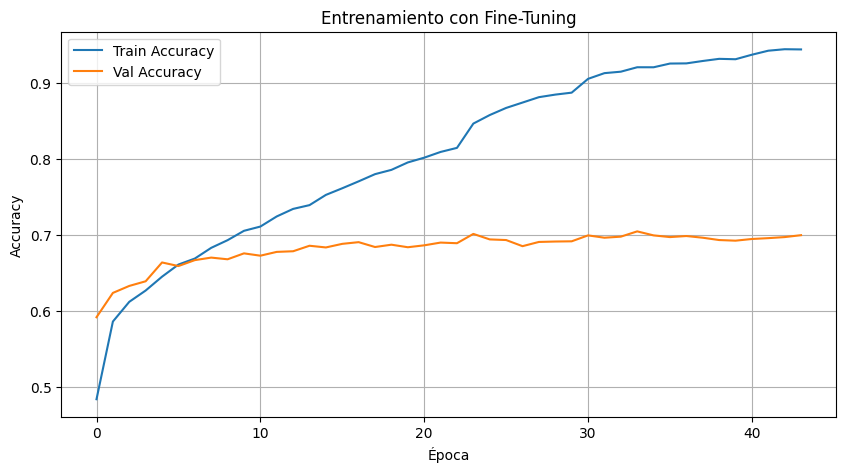


✓ Mejor Val Accuracy: 0.705
✓ Modelo guardado en: best_resnet18_finetuned.pth


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== CONFIGURACIÓN ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

BATCH_SIZE = 32  # Reduce si tienes poca GPU RAM
EPOCHS = 50
LEARNING_RATE = 1e-4  # LR bajo para fine-tuning
WEIGHT_DECAY = 1e-4
PATIENCE = 10

EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# ========== DATASET ==========
class FER2013RGB(Dataset):
    def __init__(self, csv_path, usage="Training", transform=None):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        pixels = np.array(list(map(int, self.data.loc[idx, 'pixels'].split())))
        pixels = pixels.reshape(48, 48).astype(np.uint8)
        pixels = np.stack([pixels]*3, axis=-1)  # Convertir a RGB
        label = int(self.data.loc[idx, 'emotion'])
        
        if self.transform:
            pixels = self.transform(pixels)
        
        return pixels, label

# ========== DATA AUGMENTATION FUERTE ==========
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ========== CARGAR DATOS ==========
train_dataset = FER2013RGB('fer2013.csv', usage='Training', transform=train_transform)
val_dataset = FER2013RGB('fer2013.csv', usage='PublicTest', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train: {len(train_dataset)} | Val: {len(val_dataset)}')

# ========== MODELO CON FINE-TUNING ==========
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# DESCONGELAR TODAS LAS CAPAS (fine-tuning completo)
for param in model.parameters():
    param.requires_grad = True

# Reemplazar última capa
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7)
)

model = model.to(device)

# ========== OPTIMIZACIÓN ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# ========== EARLY STOPPING ==========
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False
    
    def __call__(self, val_acc):
        if val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.counter = 0
            return True  # Mejoró
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

early_stopping = EarlyStopping(patience=PATIENCE)

# ========== ENTRENAMIENTO ==========
train_accs, val_accs = [], []
best_val_acc = 0

for epoch in range(1, EPOCHS + 1):
    # TRAIN
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    train_acc = train_correct / train_total
    train_accs.append(train_acc)
    
    # VALIDATION
    model.eval()
    val_correct, val_total = 0, 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    val_accs.append(val_acc)
    
    # Scheduler
    scheduler.step(val_acc)
    
    print(f'Epoch {epoch:02d}/{EPOCHS} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
    
    # Guardar mejor modelo
    if early_stopping(val_acc):
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet18_finetuned.pth')
        print(f'✓ Modelo guardado (Val Acc: {val_acc:.3f})')
    
    if early_stopping.early_stop:
        print(f'Early stopping activado en época {epoch}')
        break

# ========== VISUALIZACIÓN ==========
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Entrenamiento con Fine-Tuning')
plt.legend()
plt.grid(True)
plt.show()

print(f'\n✓ Mejor Val Accuracy: {best_val_acc:.3f}')
print(f'✓ Modelo guardado en: best_resnet18_finetuned.pth')

# Probar EMOCIONES

Predicción: Fear (confianza: 0.44)


C:\Users\Javier\AppData\Local\Temp\ipykernel_22492\110547587.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18_finetuned.p

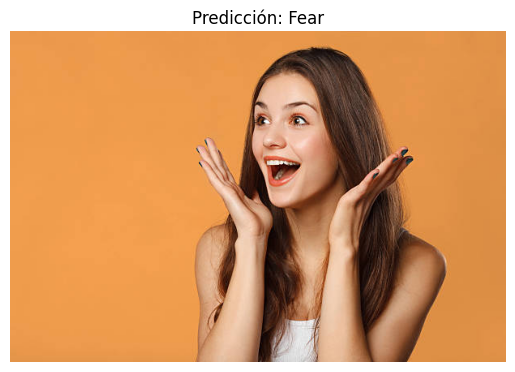

In [12]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Etiquetas de emoción en FER2013
EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# 1. Reconstruye la arquitectura y carga los pesos
model = models.resnet18(weights=None)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 7)
)
model.load_state_dict(torch.load('best_resnet18_finetuned.pth', map_location='cpu'))
model.eval()

# 2. Transforms: igual a entrenamiento (resize, tensor, normalización)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Prueba sobre una imagen facial
img_path = 'istockphoto-629771548-612x612.jpg'  # Cambia por la imagen que quieres
img = Image.open(img_path).convert('RGB')
img_tensor = preprocess(img).unsqueeze(0)  # (1, 3, 224, 224)

with torch.no_grad():
    output = model(img_tensor)
    probas = torch.softmax(output, dim=1)
    pred_idx = probas.argmax(dim=1).item()
    pred_label = EMOTIONS[pred_idx]
    conf = probas[0, pred_idx].item()

print(f"Predicción: {pred_label} (confianza: {conf:.2f})")

# 4. Visualiza la imagen y la emoción
plt.imshow(np.asarray(img))
plt.title(f"Predicción: {pred_label}")
plt.axis('off')
plt.show()


# OJOS

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Tu estructura actual
original_path = 'dataset'

# Crear estructura train/test
os.makedirs('mrl_dataset/train/Closed', exist_ok=True)
os.makedirs('mrl_dataset/train/Open', exist_ok=True)
os.makedirs('mrl_dataset/test/Closed', exist_ok=True)
os.makedirs('mrl_dataset/test/Open', exist_ok=True)

# Obtener todas las imágenes
closed_path = os.path.join(original_path, 'Closed')
open_path = os.path.join(original_path, 'Open')

closed_imgs = [os.path.join(closed_path, f) for f in os.listdir(closed_path) 
               if f.endswith(('.jpg', '.png', '.jpeg'))]
open_imgs = [os.path.join(open_path, f) for f in os.listdir(open_path) 
             if f.endswith(('.jpg', '.png', '.jpeg'))]

print(f"Imágenes cerradas: {len(closed_imgs)}")
print(f"Imágenes abiertas: {len(open_imgs)}")

# Dividir 80% train, 20% test
closed_train, closed_test = train_test_split(closed_imgs, test_size=0.2, random_state=42)
open_train, open_test = train_test_split(open_imgs, test_size=0.2, random_state=42)

# Copiar archivos (esto puede tardar unos minutos)
print("\nCopiando archivos a train/Closed...")
for img in closed_train:
    shutil.copy(img, 'mrl_dataset/train/Closed/')

print("Copiando archivos a test/Closed...")
for img in closed_test:
    shutil.copy(img, 'mrl_dataset/test/Closed/')

print("Copiando archivos a train/Open...")
for img in open_train:
    shutil.copy(img, 'mrl_dataset/train/Open/')

print("Copiando archivos a test/Open...")
for img in open_test:
    shutil.copy(img, 'mrl_dataset/test/Open/')

print('\n✓ Dataset organizado correctamente!')
print(f'Train Closed: {len(closed_train)}')
print(f'Train Open: {len(open_train)}')
print(f'Test Closed: {len(closed_test)}')
print(f'Test Open: {len(open_test)}')


Imágenes cerradas: 2000
Imágenes abiertas: 2000

Copiando archivos a train/Closed...
Copiando archivos a test/Closed...
Copiando archivos a train/Open...
Copiando archivos a test/Open...

✓ Dataset organizado correctamente!
Train Closed: 1600
Train Open: 1600
Test Closed: 400
Test Open: 400


# Train


Usando dispositivo: cuda
Train: 3200 imágenes
Val: 800 imágenes


c:\Users\Javier\anaconda3\envs\VC_P5_emotions\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Iniciando entrenamiento...

Epoch 01/15 | Train Loss: 0.1313 Acc: 0.955 | Val Loss: 0.0052 Acc: 1.000
  ✓ Modelo guardado (Val Acc: 1.000)
Epoch 02/15 | Train Loss: 0.0074 Acc: 0.998 | Val Loss: 0.0011 Acc: 1.000
Epoch 03/15 | Train Loss: 0.0044 Acc: 0.998 | Val Loss: 0.0015 Acc: 1.000
Epoch 04/15 | Train Loss: 0.0013 Acc: 1.000 | Val Loss: 0.0006 Acc: 1.000
Epoch 05/15 | Train Loss: 0.0021 Acc: 0.999 | Val Loss: 0.0006 Acc: 1.000
Epoch 06/15 | Train Loss: 0.0009 Acc: 1.000 | Val Loss: 0.0003 Acc: 1.000
Epoch 07/15 | Train Loss: 0.0007 Acc: 1.000 | Val Loss: 0.0002 Acc: 1.000
Epoch 08/15 | Train Loss: 0.0022 Acc: 1.000 | Val Loss: 0.0001 Acc: 1.000
Epoch 09/15 | Train Loss: 0.0004 Acc: 1.000 | Val Loss: 0.0001 Acc: 1.000
Epoch 10/15 | Train Loss: 0.0015 Acc: 1.000 | Val Loss: 0.0001 Acc: 1.000
Epoch 11/15 | Train Loss: 0.0003 Acc: 1.000 | Val Loss: 0.0001 Acc: 1.000
Epoch 12/15 | Train Loss: 0.0003 Acc: 1.000 | Val Loss: 0.0001 Acc: 1.000
Epoch 13/15 | Train Loss: 0.0002 Acc: 1.000 | 

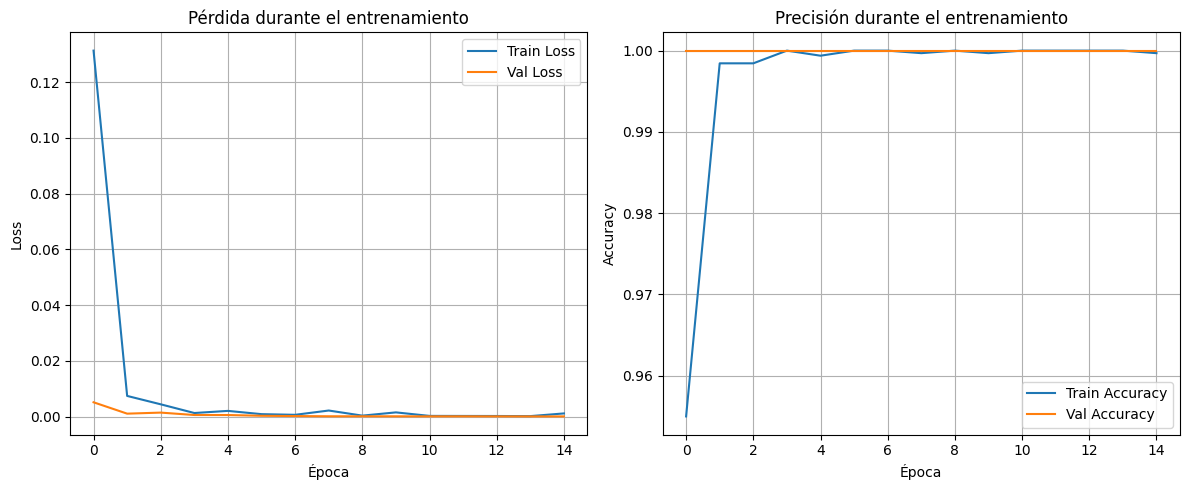

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# ========== CONFIGURACIÓN ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 1e-4

# ========== DATASET ==========
class EyeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # 0 = cerrado, 1 = abierto
        for label, folder in enumerate(['Closed', 'Open']):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.exists(folder_path):
                print(f"ADVERTENCIA: No se encuentra {folder_path}")
                continue
            for img_name in os.listdir(folder_path):
                if img_name.endswith(('.jpg', '.png', '.jpeg')):
                    self.images.append(os.path.join(folder_path, img_name))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ========== TRANSFORMS ==========
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ========== CARGAR DATOS ==========
train_dataset = EyeDataset('mrl_dataset/train', transform=train_transform)
val_dataset = EyeDataset('mrl_dataset/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train: {len(train_dataset)} imágenes')
print(f'Val: {len(val_dataset)} imágenes')

# ========== MODELO ==========
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modificar última capa para 2 clases
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)

model = model.to(device)

# ========== OPTIMIZACIÓN ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# ========== ENTRENAMIENTO ==========
best_acc = 0
train_accs, val_accs, train_losses, val_losses = [], [], [], []

print("\nIniciando entrenamiento...\n")

for epoch in range(1, EPOCHS + 1):
    # TRAIN
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # VALIDATION
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss = running_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Scheduler
    scheduler.step(val_acc)
    
    print(f'Epoch {epoch:02d}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}')
    
    # Guardar mejor modelo
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'eye_model.pth')
        print(f'  ✓ Modelo guardado (Val Acc: {val_acc:.3f})')

print(f'\n✓ Entrenamiento completado!')
print(f'✓ Mejor Val Accuracy: {best_acc:.3f}')
print(f'✓ Modelo guardado en: eye_model.pth')

# ========== VISUALIZACIÓN ==========
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Probar OJOS


C:\Users\Javier\AppData\Local\Temp\ipykernel_22492\2542975445.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('eye_model.pth', map_loca

Se detectaron 1 cara(s)
Se detectaron 3 ojo(s)
  Ojo 1: Abierto (92.99%)
  Ojo 2: Cerrado (73.59%)
  Ojo 3: Cerrado (93.28%)

Resultado: OJOS ABIERTOS


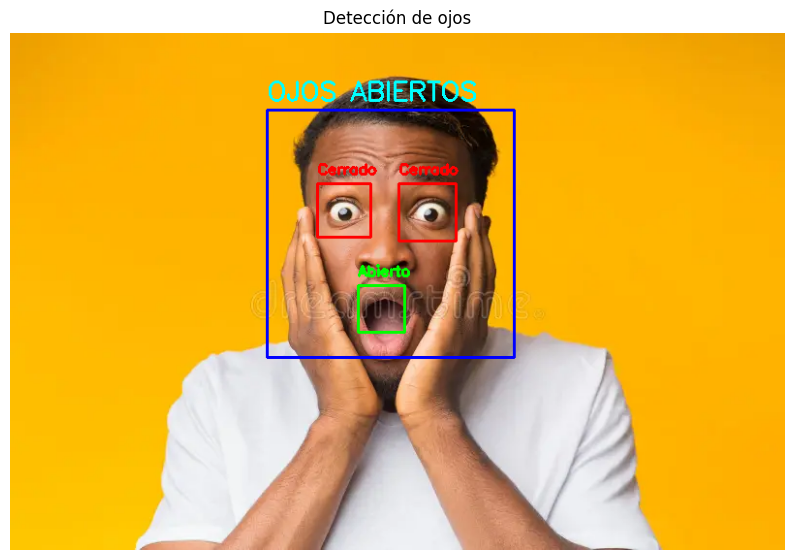

In [13]:
import cv2
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ========== CARGAR MODELO ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=None)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 2)
)
model.load_state_dict(torch.load('eye_model.pth', map_location=device))
model.eval()
model.to(device)

# ========== TRANSFORM ==========
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ========== DETECTORES ==========
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# ========== FUNCIÓN PARA DETECTAR OJOS Y PREDECIR ==========
def detect_and_predict(image_path):
    """
    Detecta cara y ojos, luego predice si están abiertos o cerrados
    """
    # Cargar imagen
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: No se pudo cargar la imagen {image_path}")
        return
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detectar caras
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    if len(faces) == 0:
        print("No se detectó ninguna cara en la imagen")
        return
    
    print(f"Se detectaron {len(faces)} cara(s)")
    
    for (x, y, w, h) in faces:
        # Región de la cara
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        # Dibujar rectángulo en cara
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Detectar ojos dentro de la cara
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 10)
        
        print(f"Se detectaron {len(eyes)} ojo(s)")
        
        if len(eyes) == 0:
            print("No se detectaron ojos. Intenta con otra imagen o ajusta los parámetros.")
            continue
        
        eye_predictions = []
        
        for i, (ex, ey, ew, eh) in enumerate(eyes):
            # Recortar región del ojo
            eye_img = roi_color[ey:ey+eh, ex:ex+ew]
            
            # Convertir a RGB y PIL
            eye_rgb = cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB)
            eye_pil = Image.fromarray(eye_rgb)
            
            # Preprocesar y predecir
            eye_tensor = preprocess(eye_pil).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model(eye_tensor)
                probas = torch.softmax(output, dim=1)
                pred_idx = probas.argmax(dim=1).item()
                confidence = probas[0, pred_idx].item()
            
            label = "Cerrado" if pred_idx == 0 else "Abierto"
            eye_predictions.append((label, confidence))
            
            # Dibujar rectángulo en ojo
            color = (0, 0, 255) if pred_idx == 0 else (0, 255, 0)
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), color, 2)
            cv2.putText(roi_color, f'{label}', (ex, ey-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            print(f"  Ojo {i+1}: {label} ({confidence:.2%})")
        
        # Resultado general
        if len(eye_predictions) >= 2:
            if all(pred[0] == "Cerrado" for pred in eye_predictions):
                status = "OJOS CERRADOS"
            else:
                status = "OJOS ABIERTOS"
            
            cv2.putText(img, status, (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
            print(f"\nResultado: {status}")
    
    # Mostrar imagen con detecciones
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title('Detección de ojos')
    plt.axis('off')
    plt.show()

# ========== PROBAR ==========
# Cambia esta ruta por una imagen de cara completa
detect_and_predict('surprised-black-man-touching-face-posing-over-orange-background-omg-surprised-black-man-touching-face-looking-camera-shock-169071007.jpg')


# Probar OJOS y camara


In [ ]:
import cv2
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np

# Cargar modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=None)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2)
)
model.load_state_dict(torch.load('eye_model.pth', map_location=device))
model.eval()
model.to(device)

# Transform
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Detectores
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

cap = cv2.VideoCapture(0)
print("Presiona 'q' para salir")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        
        # Detectar ojos dentro de la cara
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 10)
        
        eyes_status = []
        for (ex, ey, ew, eh) in eyes:
            # Recortar ojo
            eye_img = roi_color[ey:ey+eh, ex:ex+ew]
            eye_rgb = cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB)
            eye_pil = Image.fromarray(eye_rgb)
            eye_tensor = preprocess(eye_pil).unsqueeze(0).to(device)
            
            # Predecir
            with torch.no_grad():
                output = model(eye_tensor)
                pred = output.argmax(dim=1).item()
            
            eyes_status.append(pred)
            
            # Dibujar rectángulo en ojo
            color = (0, 255, 0) if pred == 1 else (0, 0, 255)
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), color, 2)
        
        # Estado general
        if len(eyes_status) >= 2:
            if all(s == 0 for s in eyes_status):
                status = "OJOS CERRADOS"
                color = (0, 0, 255)
            else:
                status = "OJOS ABIERTOS"
                color = (0, 255, 0)
            
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            cv2.putText(frame, status, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    cv2.imshow('Detector de Ojos', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
